In [1]:
import json
import os
import numpy as np
import pandas as pd

In [2]:
documents_path = 'dis-project-1-document-retrieval/corpus.json/corpus.json'

In [3]:
with open(documents_path) as f:
    documents = json.load(f)

In [4]:
train_queries_path = 'dis-project-1-document-retrieval/train.csv'

In [5]:
# Load the training queries
train_queries = pd.read_csv(train_queries_path)

In [ ]:
count = 0
for _, query in train_queries.iterrows():
    query_id = query['query_id']
    query_text = query['query']
    relevant_docs = query['positive_docs']
    language = query['lang']
    if count == 1:
        print(query_id, query_text, relevant_docs, language)
        break
    count += 1


In [ ]:
documents[0]

In [6]:
def get_doc_by_id(doc_id):
    return next(doc for doc in documents if doc['docid'] == doc_id)

In [27]:
# count the queries which have relevant doucments whose language is not the query language
count = 0
for _, query in train_queries.iterrows():
    query_id = query['query_id']
    query_text = query['query']
    relevant_docs = query['positive_docs']
    language = query['lang']
    for doc_id in relevant_docs.split():
        doc_language = get_doc_by_id(doc_id)['lang']
        if language != doc_language:
            count += 1
            print(f'Query {query_id} has relevant document {doc_id} with language {doc_language} which is different from the query language {query_language}')

In [28]:
print(f'Total queries with relevant documents with different language: {count}')

Total queries with relevant documents with different language: 0


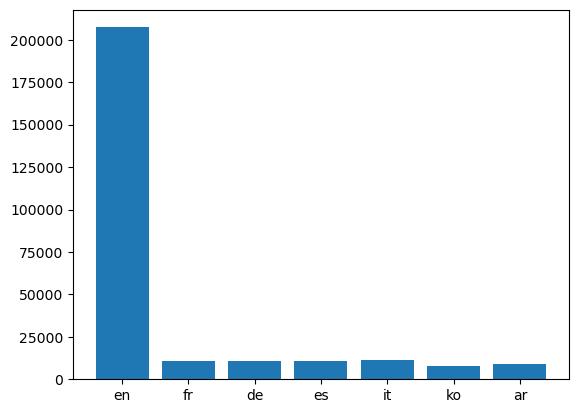

In [30]:
# look at the distibution of the langauges of the documents
from collections import Counter
doc_languages = [doc['lang'] for doc in documents]
doc_languages_counter = Counter(doc_languages)
# plot the distribution of the languages
import matplotlib.pyplot as plt
plt.bar(doc_languages_counter.keys(), doc_languages_counter.values())
plt.show()


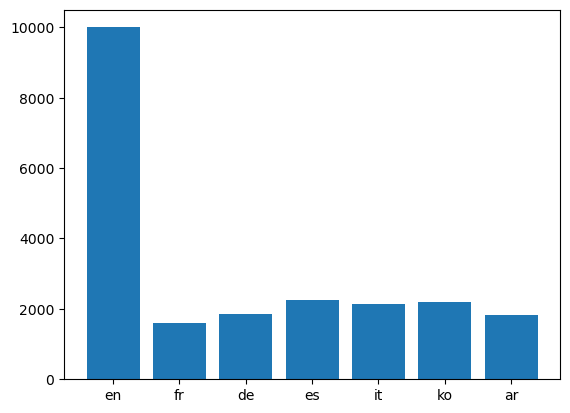

In [32]:
# look at the distibution of the langauges of the train queries
query_languages = train_queries['lang']
query_languages_counter = Counter(query_languages)
# plot the distribution of the languages
plt.bar(query_languages_counter.keys(), query_languages_counter.values())
plt.show()

In [35]:
import torch
from transformers import BertTokenizer, BertModel

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [36]:
query_text = 'What is the capital of France?'
tokenized_text = tokenizer.tokenize(query_text)
print(tokenized_text)

['what', 'is', 'the', 'capital', 'of', 'france', '?']


In [37]:
input_ids = tokenizer.encode(query_text, add_special_tokens=True)
print(input_ids)

[101, 2054, 2003, 1996, 3007, 1997, 2605, 1029, 102]


In [ ]:
# print all the

## TF-IDF

### Preprocessing

In [16]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
from nltk.corpus import stopwords

In [18]:
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optional, for additional wordnet languages

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/robinfaro/nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/robinfaro/nltk_data...


True

In [8]:
def get_langauge(lang_id):
    """
    Returns the language name given the language id in order to pass it to the stopwords function
    """
    cases = {
        'en' : 'english',
        'de' : 'german',
        'fr' : 'french',
        'es' : 'spanish',
        'it' : 'italian',
        'ar' : 'arabic',
        'ko' : 'korean'
    }
    return cases.get(lang_id, 'unknown') 

In [9]:
def preprocess_text(text, language_id):
    """
    Preprocess the text by removing stopwords, stemming and lemmatizing the text
    """
    # remove stopwords
    stop_words = set(stopwords.words(get_langauge(language_id)))
    words = nltk.word_tokenize(text)
    words = [word for word in words if word.lower() not in stop_words]
    # stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return words

### Function definition

In [10]:
def tf(term, doc):
    """
    Compute the term frequency of a term in a document

    :param term: the term to compute its frequency
    :param doc: the document to compute the frequency of the term in

    :return: the term frequency of the term in the document
    """
    f_t = doc.count(term)
    max_f = max([doc.count(t) for t in set(doc)])
    return f_t / max_f

def idf(term, documents):
    """
    Compute the inverse document frequency of a term in a list of documents
    :param term: the term to compute its inverse document frequency
    :param documents: the list of documents (SAME LANGUAGE of term)to compute the inverse document frequency of the term in
    """
    n = len(documents)
    n_t = sum([1 for doc in documents if term in doc])
    return np.log(n / n_t)

def pivoted_unique_query_norm_tf_idf(term, doc, documents, s=0.2):
    """
    Compute the term frequency - inverse document frequency of a term in a document
    """
    # calculate the number of unique terms in the document
    pivot = 0
    for document in documents:
        unique_terms = set(document)
        pivot += len(unique_terms)
    pivot /= len(documents)
    u = len(set(doc))
    tf = tf(term, doc)
    idf = idf(term, documents)

    return tf * idf * ((1-s)* pivot + s * u)

In [11]:
def compute_precison_at_k(retrieved_docs, relevant_docs, k):
    """
    Compute the precision at k
    """
    count = set(retrieved_docs[:k]).intersection(set(relevant_docs))
    return len(count) / k

def compute_recall_at_k(retrieved_docs, relevant_docs, k):
    """
    Compute the recall at k
    """
    count = set(retrieved_docs[:k]).intersection(set(relevant_docs))
    return len(count) / len(relevant_docs)

def compute_f1_at_k(retrieved_docs, relevant_docs, k):
    """
    Compute the f1 score at k
    """
    precision = compute_precison_at_k(retrieved_docs, relevant_docs, k)
    recall = compute_recall_at_k(retrieved_docs, relevant_docs, k)
    return 2 * precision * recall / (precision + recall)

## Experiments

In [13]:
# select only english documents

'Mars Hill Church was a Christian megachurch, founded by Mark Driscoll, Lief Moi, and Mike Gunn. It was a multi-site church based in Seattle, Washington and grew from a home Bible study to 15 locations in 4 U.S. states. Services were offered at its 15 locations; the church also podcast content of weekend services, and of conferences, on the Internet with more than 260,000 sermon views online every week. In 2013, Mars Hill had a membership of 6,489 and average weekly attendance of 12,329. Following controversy in 2014 involving founding pastor Mark Driscoll, attendance dropped to 8,0009,000 people per week.\n\nAt the end of September, 2014, an investigation by the church elders found "bullying" and "patterns of persistent sinful behavior" by Driscoll. The church elders crafted a "restoration" plan to help Driscoll and save the church. Instead, Driscoll declined the restoration plan and resigned. On October 31, 2014, lead pastor Dave Bruskas announced plans to dissolve the church\'s 13 r

In [20]:
def create_vocabulary_language(documents, languages):
    """
    Create the vocabularies for all the languages in the documents
    """
    vocabularies = {}
    for language in languages:
        vocabularies[language] = set()
    for doc in documents:
        language = doc['lang']
        text = doc['text']
        preprocessed_text = preprocess_text(text, language)
        vocabularies[language].update(set(preprocessed_text))
    return vocabularies

In [22]:
languages = ['en', 'de', 'fr', 'es', 'it', 'ar', 'ko']

vocabularies = create_vocabulary_language(documents, languages)

In [ ]:
# save the vocabularies for each language in a json file
for language in languages:
    with open(f'vocabulary_{language}.json', 'w') as f:
        json.dump(list(vocabularies[language]), f)
